# Hindmarsh-Rose model

Hindmarsh-Rose model is a neuron model. It is composed of 3 differential equations and can generate several firing patterns by tuning patterns.

In [1]:
import numpy as np
import brainpy as bp
import matplotlib.pyplot as plt

bp.backend.set(dt=0.05)
bp.set_default_odeint('rk4')

In [2]:
class HindmarshRose(bp.NeuGroup):
    target_backend = 'general'

    @staticmethod
    def derivative(V, y, z, t, a, b, c, d, r, s, x_r, Isyn):
        dV = y - a * V ** 3 + b * V * V - z + Isyn
        dy = c - d * V * V - y
        dz = r * (s * (V - x_r) - z)
        return dV, dy, dz

    def __init__(self, size, a=1., b=3., c=1., d=5., s=4., x_r=-1.6,
                 r=0.01, Vth=1.9, **kwargs):
        # parameters
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.s = s
        self.x_r = x_r
        self.r = r
        self.Vth = Vth

        # variables
        num = bp.size2len(size)
        self.V = -1.6 * bp.ops.ones(num)
        self.y = -10 * bp.ops.ones(num)
        self.z = bp.ops.zeros(num)
        self.input = bp.ops.zeros(num)
        self.spike = bp.ops.zeros(num, dtype=bool)

        self.integral = bp.odeint(f=self.derivative)

        super(HindmarshRose, self).__init__(size=size, **kwargs)

    def update(self, _t):
        V, y, z = self.integral(self.V, self.y, self.z, _t,
                                self.a, self.b, self.c, self.d,
                                self.r, self.s, self.x_r, self.input)
        self.spike = (V >= self.Vth) * (self.V < self.Vth)
        self.V = V
        self.y = y
        self.z = z
        self.input[:] = 0.

In [3]:
types = ['quiescence', 'spiking', 'bursting', 'irregular_spiking', 'irregular_bursting']
bs = np.array([1.0, 3.5, 2.5, 2.95, 2.8])
Is = np.array([2.0, 5.0, 3.0, 3.3, 3.7])

In [4]:
# define neuron type
group = HindmarshRose(len(types), b=bs,  monitors=['V'])
group.run(1e3, inputs=['input', Is], report=True)

Compilation used 0.0006 s.
Start running ...
Run 10.0% used 0.197 s.
Run 20.0% used 0.357 s.
Run 30.0% used 0.511 s.
Run 40.0% used 0.671 s.
Run 50.0% used 0.831 s.
Run 60.0% used 0.989 s.
Run 70.0% used 1.153 s.
Run 80.0% used 1.311 s.
Run 90.0% used 1.490 s.
Run 100.0% used 1.653 s.
Simulation is done in 1.653 s.



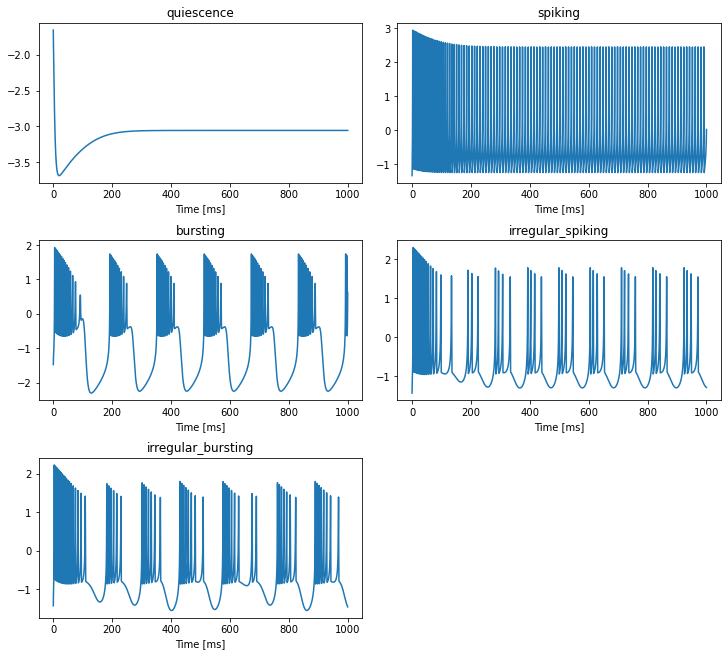

In [5]:
fig, gs = bp.visualize.get_figure(row_num=3, col_num=2, row_len=3, col_len=5)
for i, mode in enumerate(types):
    # plot
    fig.add_subplot(gs[i // 2, i % 2])
    plt.plot(group.mon.ts, group.mon.V[:, i])
    plt.title(mode)
    plt.xlabel('Time [ms]')
plt.show()